In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import pandas as pd
import torch
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pytorch_lightning as pl

import opf
import opf.utils
import opf.dataset
import utils

# fix issues with figures using underscores in their names
mpl.rcParams["text.usetex"] = False


In [3]:
case_name = "case118"
run_id = "324jt1ic"
data_dir = "../data/"
log_dir = "../logs/"

Unnormalized adjacency matrix
Non-zero edges: 358
Connected components: 1


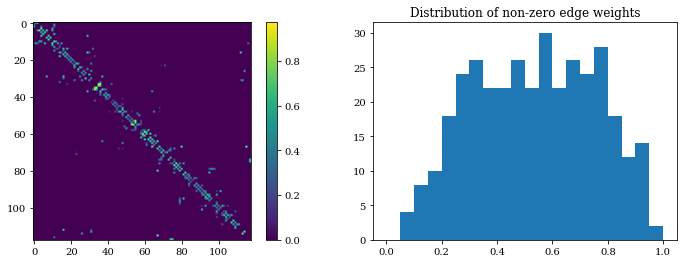

In [4]:
dm = opf.dataset.CaseDataModule(case_name, "../data", adj_threshold=0.01)
print("Unnormalized adjacency matrix")
opf.utils.graph_info(dm.gso(normalize=False), plot=True)

In [5]:
api = wandb.Api()
run = api.run(f"damowerko/opf/{run_id}")

save_dir = f"../figures/{run.config['case_name']}/"
os.makedirs(save_dir, exist_ok=True)


def save(title: str, fig=plt):
    fig.savefig(save_dir + f"{title}.png")
    fig.savefig(save_dir + f"{title}.pdf")


barrier = opf.utils.create_model(dm, run.config)
utils.load_checkpoint(barrier, run.id, log_dir)


In [6]:
barrier.detailed_metrics = True
outputs = utils.test(barrier, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/damow/.pyenv/versions/3.9.6/envs/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1295: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
/home/damow/.pyenv/versions/3.9.6/envs/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

In [7]:
df = outputs.copy()
(df[["test/cost","test/inequality/rate"]].mean(),
df[[
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]].max())

(test/cost               1557.345999
 test/inequality/rate       0.001344
 dtype: float64,
 test/inequality/error_max                             0.467121
 test/inequality/active_power/error_max                0.000000
 test/inequality/reactive_power/error_max              0.000000
 test/inequality/voltage_magnitude/error_max           0.000000
 test/inequality/forward_rate/error_max                0.000000
 test/inequality/backward_rate/error_max               0.000000
 test/inequality/voltage_angle_difference/error_max    0.467121
 dtype: float64)

# Statistics

In [8]:
print(f"""
Mean violation rate: {df["test/inequality/rate"].max()}
Rate of any violation: {(df["test/inequality/rate"] > 1e-8).sum() / len(df)}
GNN Cost: {df["test/cost"].mean()}
IPOPT Cost: {df["acopf/cost"].mean()}
""")


Mean violation rate: 0.0013440860215053762
Rate of any violation: 1.0
GNN Cost: 1557.3459989789733
IPOPT Cost: 836.1014911699283



# Histograms

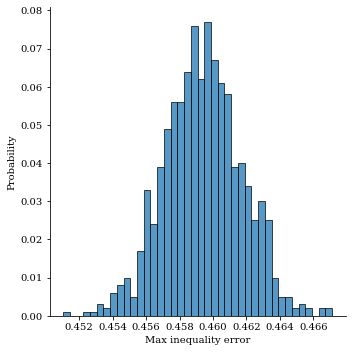

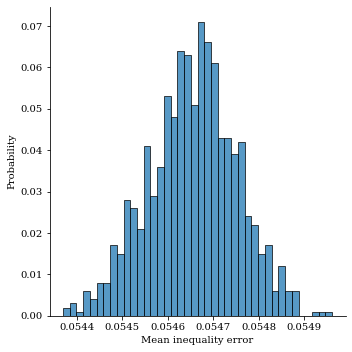

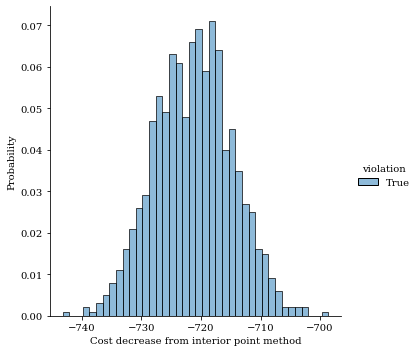

In [9]:
bins = 40

sns.displot(df, x="test/inequality/error_max", stat="probability", bins=bins)
plt.xlabel("Max inequality error")
save("error_max")

sns.displot(df, x="test/inequality/error_mean", stat="probability", bins=bins)
plt.xlabel("Mean inequality error")
save("error_mean")

# Cost improvement
df["test/cost/difference"] = df["acopf/cost"] - df["test/cost"]
df["violation"] = df["test/inequality/rate"] > 1e-8
sns.displot(df, x="test/cost/difference", hue="violation", stat="probability", bins=bins)
plt.xlabel("Cost decrease from interior point method")
save("costs")

# Visualizing Violations

In [10]:
sort_term = "test/inequality/error_max"
quantile = 1

s = df[sort_term]
index = (s.sort_values()[::-1] <= s.quantile(quantile)).idxmax()
print(sort_term, s[index])
print("Idx", index)
df.iloc[index][[
    "test/cost",
    "test/equality/bus_power/error_max",
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]]

test/inequality/error_max 0.46712102523031973
Idx 540


test/cost                                              1557.35
test/equality/bus_power/error_max                      18.7531
test/inequality/error_max                             0.467121
test/inequality/active_power/error_max                       0
test/inequality/reactive_power/error_max                     0
test/inequality/voltage_magnitude/error_max                  0
test/inequality/forward_rate/error_max                       0
test/inequality/backward_rate/error_max                      0
test/inequality/voltage_angle_difference/error_max    0.467121
Name: 540, dtype: object

/home/damow/.pyenv/versions/3.9.6/envs/opf/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


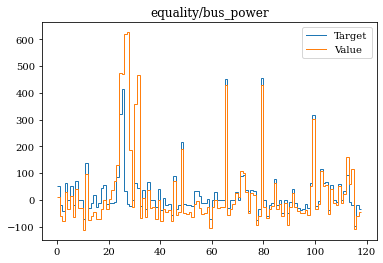

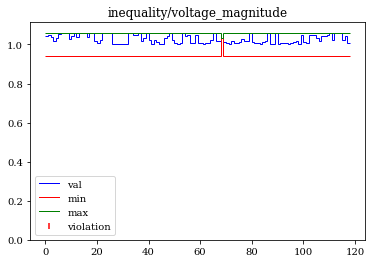

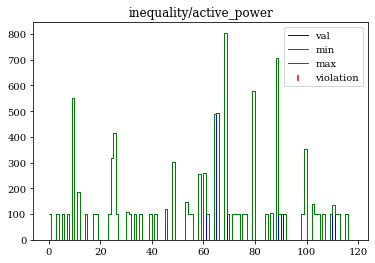

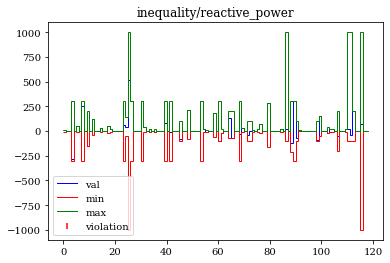

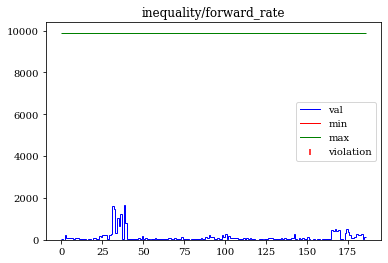

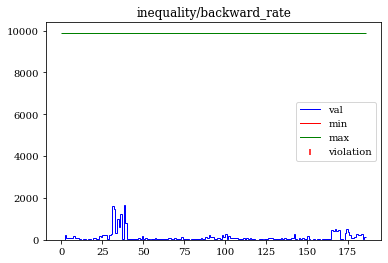

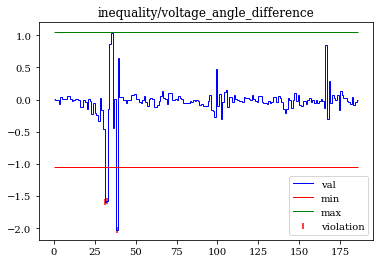

In [11]:
import opf.plot

dataset = list(dm.test_dataloader())
barrier.double()
load = dataset[index][0].double() @ barrier.powerflow_parameters.load_matrix
with torch.no_grad():
    variables, _, _, _ = barrier._step_helper(*barrier(load), True)
plots = opf.plot.plot_constraints(variables, barrier.powerflow_parameters)

In [12]:
forward_error = df.iloc[index]["test/inequality/forward_rate/error_max"]
backward_error = df.iloc[index]["test/inequality/backward_rate/error_max"]

increase = 1 + torch.clamp((torch.maximum(variables.Sf.abs(), variables.St.abs()) - barrier.powerflow_parameters.rate_a) / barrier.powerflow_parameters.rate_a, min=0) \
    .squeeze().detach().numpy()
net = barrier.net_wrapper.net
original = net.line.copy()
barrier.net_wrapper.set_load_sparse(variables.Sd.real.squeeze(), variables.Sd.imag.squeeze())
net.line["max_i_ka"] *= increase
bus = torch.as_tensor(barrier.net_wrapper.optimal_ac()[0]).double().unsqueeze(0)
cost, constraints = barrier.optimal_power_flow(barrier.bus_from_polar(bus), load)
net.line = original

print("IPOPT Original Cost:", df.iloc[index]["acopf/cost"])
print("IPOPT Relaxed Cost:", cost.item())
print("GNN Cost", df.iloc[index]["test/cost"])

AttributeError: 'PowerflowParameters' object has no attribute 'rate_a'